In [92]:
import pandas as pd
import numpy as np
import string
from matplotlib import pyplot as plt

#Data Preprocessing and Feature Engineering
import nltk
nltk.download('stopwords')

from nltk.tokenize import TweetTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
import re

#Model
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anis_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anis_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\anis_\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anis_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [88]:
def read_data():
    data = pd.read_csv("train.csv")
#     df_test = pd.read_csv("test.csv")
#     print(df_test.head())
    data['textID'] = data['textID'].astype(str)
    data['text'] = data['text'].astype(str)
    data['selected_text'] = data['selected_text'].astype(str)
    data['sentiment'] = data['sentiment'].astype(str)
    data.replace({"sentiment":{"positive":2, "neutral":1, "negative":0}}, inplace=True)
    
    data = data.drop(['textID'], axis = 1)
    data['text'] = [d.lower() for d in data['text']]
    data['selected_text'] = [d.lower() for d in data['selected_text']]
    
    return data

In [ ]:
read_data()

In [89]:
# token_set = set()
# stop_word_set = set()

def build_index():
    data = read_data()
    tknzr = TweetTokenizer()
    
    stop = stopwords.words('english')
    data['tweet'] = ""
    data['without_stopwords'] = ""
    
#     global token_set
#     global stop_word_set
    
    data['tweet'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',str(x))))
    data['tweet'] = data['tweet'].apply((lambda x: re.sub("https?://[A-Za-z0-9./]+",'',str(x))))
    data['without_stopwords'] = data['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    

#         token_set = token_set.union(set(token))
#         stop_word_set = stop_word_set.union(set(tokens_words))
    return data

In [115]:
def model():
    
    data = build_index()
    X_text = data['text']
    X_tweet = data['tweet']
    X_stopwords = data['without_stopwords']
    Y = data['sentiment']
    Y = np.array(Y)

    tokenize = Tokenizer()
    tokenize.fit_on_texts(X_text.values)
    X_text = tokenize.texts_to_sequences(X_text)

    max_length = 15
    X_text = pad_sequences(X_text, maxlen = max_length, padding='post')
    
    vocab_size = len(tokenize.word_index)+1
    #print(vocab_size)

    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length = max_length))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(3, activation = 'softmax'))
    
    # compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    print(model.summary())
    
    history = model.fit(X_text, Y, epochs = 100, validation_split = 0.1, batch_size = 256)
    
    plt.clf()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'y', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.clf()
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'y', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    p_train = model.predict(X_text)
    #p_test = model.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(Y,np.argmax(p_train, axis = 1))
    #test_acc = accuracy_score(np.argmax(y_test,axis=1 ), np.argmax(p_test,axis=1))
    print(train_acc)
    #print(test_acc)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 15, 100)           2659900   
_________________________________________________________________
dropout_56 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_55 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_57 (Dropout)         (None, 32)                0         
_________________________________________________________________
activation_27 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 3)               

24732/24732 [==============================] - 7s 278us/sample - loss: 0.0328 - accuracy: 0.9889 - val_loss: 2.9683 - val_accuracy: 0.6191
Epoch 47/100
24732/24732 [==============================] - 7s 263us/sample - loss: 0.0298 - accuracy: 0.9897 - val_loss: 2.8933 - val_accuracy: 0.6097
Epoch 48/100
24732/24732 [==============================] - 6s 260us/sample - loss: 0.0295 - accuracy: 0.9900 - val_loss: 3.2645 - val_accuracy: 0.6170
Epoch 49/100
24732/24732 [==============================] - 6s 250us/sample - loss: 0.0299 - accuracy: 0.9900 - val_loss: 3.2405 - val_accuracy: 0.6133
Epoch 50/100
24732/24732 [==============================] - 6s 251us/sample - loss: 0.0274 - accuracy: 0.9902 - val_loss: 3.2989 - val_accuracy: 0.6108
Epoch 51/100
24732/24732 [==============================] - 6s 250us/sample - loss: 0.0313 - accuracy: 0.9885 - val_loss: 3.0477 - val_accuracy: 0.6206
Epoch 52/100
24732/24732 [==============================] - 6s 252us/sample - loss: 0.0307 - accuracy

Epoch 100/100
24732/24732 [==============================] - 6s 251us/sample - loss: 0.0104 - accuracy: 0.9965 - val_loss: 4.0172 - val_accuracy: 0.6068


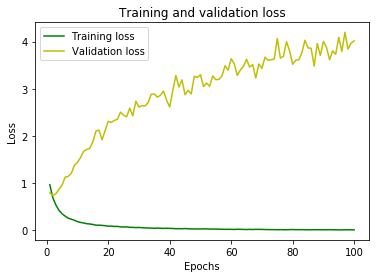

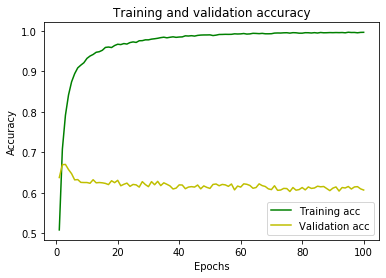

0.959353735308031


In [116]:
model()